In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mlflow
import mlflow.sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv("..//dataset//processed/final_dataset.csv")
print(df)

       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
0      2015      1    1     0                     8852.0           27913.0   
1      2015      1    1     1                     9054.0           27913.0   
2      2015      1    1     2                     9070.0           27913.0   
3      2015      1    1     3                     9163.0           27913.0   
4      2015      1    1     4                     9231.0           27913.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density  
0       

In [3]:
train_df = df[df['year']<=2018].copy()
test_df = df[df['year']>2018].copy()

In [4]:
print("train_df")
print(train_df)

train_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
0      2015      1    1     0                     8852.0           27913.0   
1      2015      1    1     1                     9054.0           27913.0   
2      2015      1    1     2                     9070.0           27913.0   
3      2015      1    1     3                     9163.0           27913.0   
4      2015      1    1     4                     9231.0           27913.0   
...     ...    ...  ...   ...                        ...               ...   
35059  2018     12   31    19                    17587.0           48974.0   
35060  2018     12   31    20                    18871.0           48974.0   
35061  2018     12   31    21                    20270.0           48974.0   
35062  2018     12   31    22                    21405.0           48974.0   
35063  2018     12   31    23                    23132.0           48974.0   

       DE_wind_speed  DE_temperature  DE_air_density  

In [5]:
print("test_df")
print(test_df)

test_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
35064  2019      1    1     0                    24905.0           48974.0   
35065  2019      1    1     1                    25208.0           48974.0   
35066  2019      1    1     2                    26568.0           48974.0   
35067  2019      1    1     3                    28500.0           48974.0   
35068  2019      1    1     4                    29808.0           48974.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density  


In [6]:
features = ['year','month','day','hour','DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']
target = 'DE_wind_generation_actual'

In [7]:
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

# Define parameter grid
param_grid = {
    'C': [0.01,0.1, 1,5,10,100,200],  # Regularization strength
    'epsilon': [0.00001,0.0001,0.001,0.01, 0.1, 1],  # Tolerance for error
    'max_iter': [1000, 5000, 10000, 50000],  # Increase iterations for convergence,
    'loss' : ['squared_epsilon_insensitive','epsilon_insensitive'],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearSVR(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Train
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_svr = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits
Best parameters: {'C': 0.01, 'epsilon': 1, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}


In [10]:
test_df['predicted_wind_generation'] = best_svr.predict(X_test_scaled)

In [12]:
from sklearn.metrics import mean_absolute_error
y_pred = best_svr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Compute R² Score
r2 = r2_score(y_test, y_pred)

print(f"Mean Abosolute Error (MSE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Abosolute Error (MSE): 4061.1646
Mean Squared Error (MSE): 24853050.9559
Root Mean Squared Error (RMSE): 4985.2834
R² Score: 0.7479


In [15]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Percentage': (abs(y_test - y_pred)/y_test) * 100
})


In [16]:
print(results_df[results_df['Percentage'] > 1000])

       Actual    Predicted        Error   Percentage
35531   661.0  7684.257948 -7023.257948  1062.520113
35532   643.0  7612.244882 -6969.244882  1083.863901
39800   400.0  4494.759839 -4094.759839  1023.689960
41072   429.0  7047.965889 -6618.965889  1542.882492
41073   427.0  6919.767921 -6492.767921  1520.554548
41074   472.0  6556.137857 -6084.137857  1289.012258
41075   526.0  6139.566310 -5613.566310  1067.217930


In [17]:
print(test_df)

       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
35064  2019      1    1     0                    24905.0           48974.0   
35065  2019      1    1     1                    25208.0           48974.0   
35066  2019      1    1     2                    26568.0           48974.0   
35067  2019      1    1     3                    28500.0           48974.0   
35068  2019      1    1     4                    29808.0           48974.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density  \
35064  

In [22]:
subset = test_df[(test_df['year'] == 2019) &
                 (test_df['month'] == 1) &
                 (test_df['day'] >=1) & (test_df['day']<=8)]

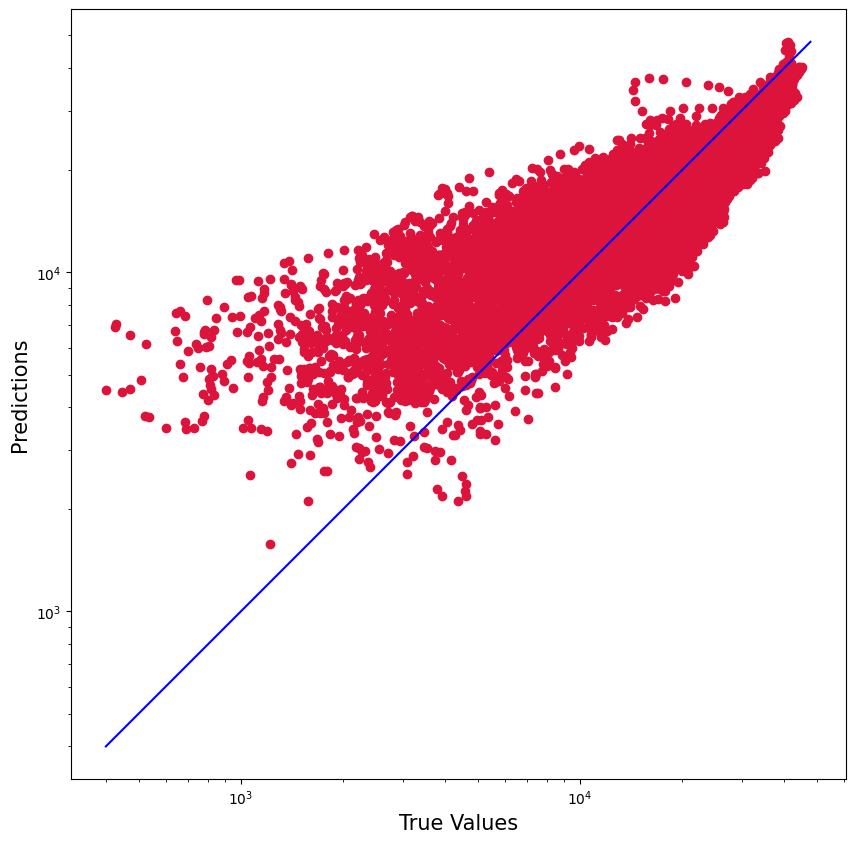

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

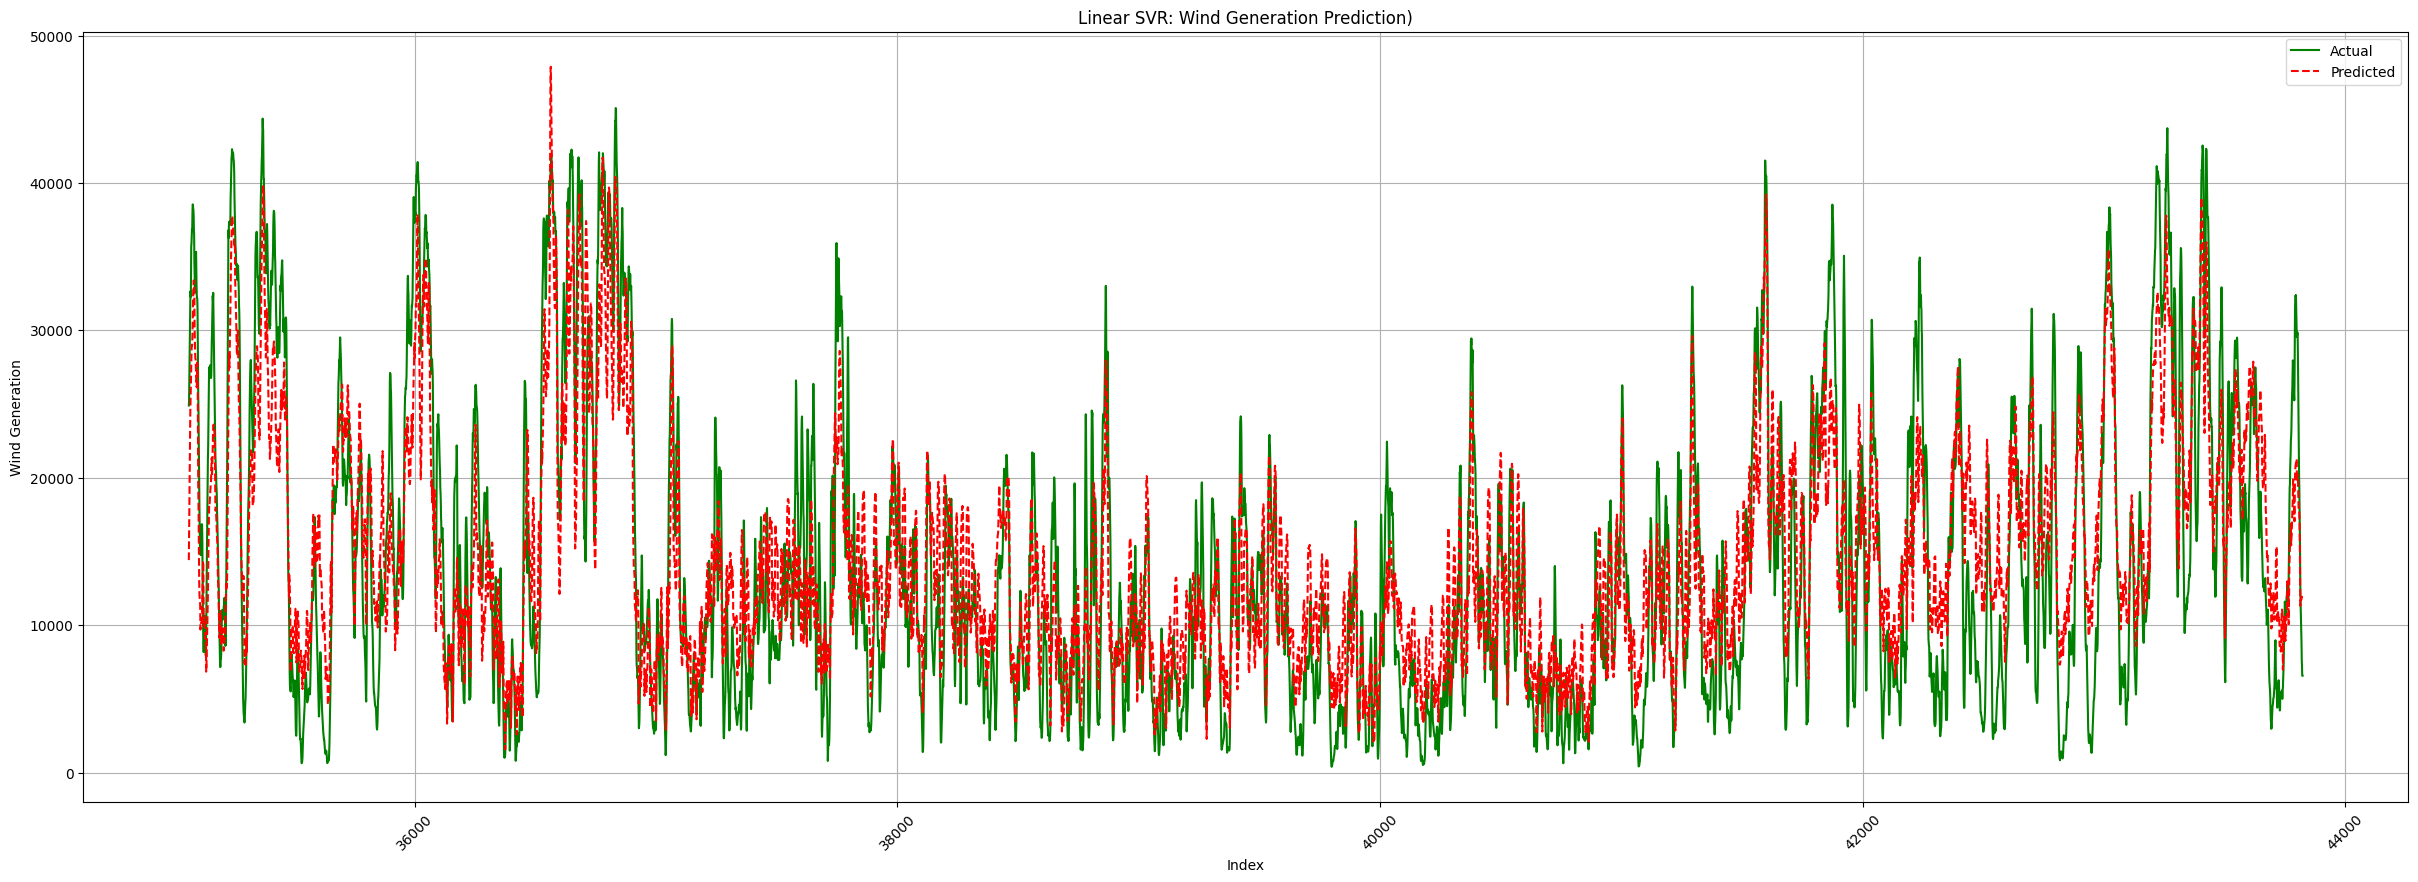

In [24]:
plt.figure(figsize=(30, 10))
plt.plot(test_df.index, test_df['DE_wind_generation_actual'], label="Actual", color="green")
plt.plot(test_df.index, test_df['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title('Linear SVR: Wind Generation Prediction)')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

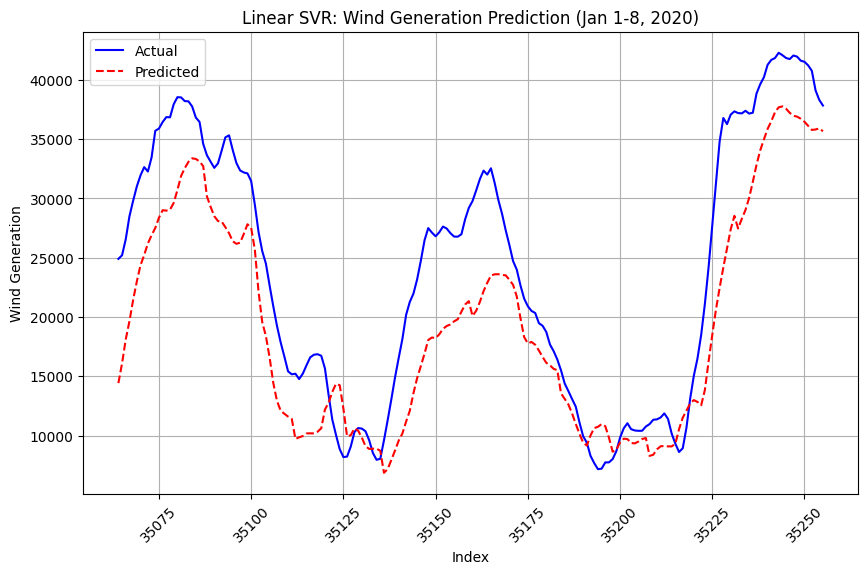

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(subset.index, subset['DE_wind_generation_actual'], label="Actual", color="blue")
plt.plot(subset.index, subset['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title('Linear SVR: Wind Generation Prediction (Jan 1-8, 2020)')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()